<a href="https://colab.research.google.com/github/ioan-hedea/deepLearning4005/blob/main/Assignment_8(DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSAIT4005 Machine and Deep Learning (2024/25 Q1) - Assignment 8

---


*Please post any feedback you have on Brightspace. Thanks!*

To start working on the assignment in Colab, save a copy on your Google Drive (`File` $\rightarrow$ `Save a copy in Drive`).

To work on the assignments locally, configure your conda environment (see instructions on Brightspace) and download this assignment as an IPython Notebook (`File` $\rightarrow$ `Download .ipynb`).

## Introduction

In this assignment you will be introduced to convolutional neural networks (CNN's). First we will introduce the covolutional operator itself (in 2D). You will learn the differences between layers that convey convolutions and those you are already familiar with (fully connected layers) and, moreover, how they relate. You will continue with the implementation of convolutional layers. Furthermore, we will introduce the concepts and implementations of pooling and its effect on the receptive field (RF) of the neurons. Last but not least, you will design and train your own CNN on the handwritten dataset (same as previous assignment).

**Prerequisites:**
* Completion of previous assignments (1-2).
* Basic knowledge of Python and Numpy. Recommended tutorial for Python and Numpy [here](https://cs231n.github.io/python-numpy-tutorial/).
* We recommend you to have a look at [this excellent tutorial on PyTorch Tensors](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).

**Learning objectives:**
* Understanding convolutions in 2D
* Understand the relationship between convolutional and fully connected layers
* Understanding the advantages of using CNN's over fully connected neural networks.
* Implementation of the convolutional operator - from scratch
* Implementation of the convolutional layer - from scratch
* Understanding and implementation of pooling layers
* Implementation and training of your own CNN

We will share the solutions one week after the assignments are published. Throughout the assignment you will validate your code by comparing the outputs of your own implementations to the equivalent PyTorch implementations.

**For your own implementations you may only use basic tensor operations from the `torch` module: no `torch.nn`, `torch.nn.F` or others.**

---

When answering coding questions make sure to write your own code within the designated part of the code block as illustrated here:

Please pay attention to the questions boxes and try to think about them. The boxes are indicated as follows:

****
**Questions?**
****

In [1]:
# Setup
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

## A3.1 Convolutional layer

Previous assignments treated the design and implementation of fully connected layers in which every neuron from a certain layer connects with all neurons in the next. In doing so, such an architecture omits potential structure inherent to the training data. This is best explained using images as training data in which the individual pixels are the input neurons. If the input layer is fully connected to the first hidden layer, it treats input pixels that are far apart and close-by on an equal footing. Isn't that strange and unnecessary? Can we not come up with something more clever such that (spatial) structure is somehow embedded in those layers?

One such a breakthrough is the use of the convolutional operator. For a particular neuron in the first hidden layer, it only connects to a localized region of the input image:

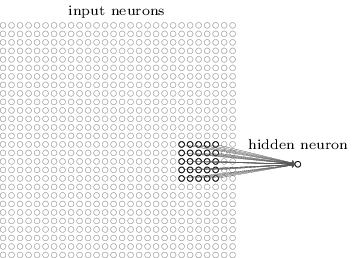

The region the hidden neuron is able to see is called the *receptive field* (RF) and it learns only the weights that connect via this region (including one overall bias term). The convolutional operator is defined as sliding this window over the input image and computing the hidden neurons step by step as indicated in the following image:

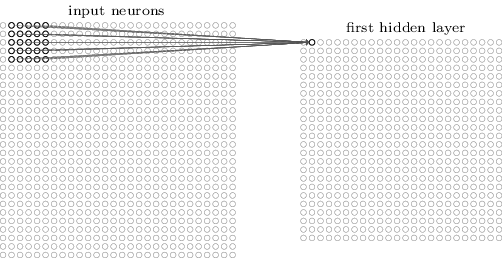

In addition, it preserves the weight values in all computations. About convolutional layers:

---

**Is this step beneficial and/or useful, or can we ignore it? What are the overall benefits of using convolutions instead of fully connected layers for images (in particular natural photos)? And what are its main drawbacks? Could you think of other domains where it could be employed?**

---

Visualizations can be found at: http://neuralnetworksanddeeplearning.com/chap6.html#introducing_convolutional_networks. The website explains beautifully the versatility and use of CNN's.

As we did in earlier assignments, we will develop our own convolutional layer from scratch and later compare it to the one predefined in the PyTorch module. Similarly as before, we will create a `class` that refers to the layer and define the convolutional operation in the `forward` statement. You might need the mathematical description for the convolutional operator which is formulated as

$$ y \left[ i, j \right] = \sum_{m = - \lfloor \frac{k}{2} \rfloor}^{\lfloor \frac{k}{2} \rfloor} \sum_{n = - \lfloor \frac{k}{2} \rfloor}^{\lfloor \frac{k}{2} \rfloor} w \left[ m, n \right] \cdot x \left[ i + m, j + n \right] $$

in which $k$ is both the width and height of the kernel (which is the localized window as referred to before) and $\lfloor \cdot \rfloor$ is the floor operator. Furthermore, notation stays consistent with previous assignments: $x$, $y$ and $w$ are input, output and weights respectively.

The exact implementation of a convolutional layer with several input and output channels can be a tricky. Please, before directly trying to implement it, think and/or draw out what exactly happens (for example: start with one to one channel, then 3 to 1 channel, then 3 to 3 channel). The following questions might help push you in the right direction:

---

**What are the shapes (and dimensions) of the in- and output feature maps? Are the same weights used across input channels? And the same for the output channels?**

---

In the lecture, padding and stride were explained as well.

---

**How should padding and stride be implemented?**

---

Again, it might be useful to visualize it before answering those questions explicitly!

You are now able to implement the `forward` step. Hint: look at the whole class before including your code.

In [38]:
class Conv2d(object):
    """
    2D convolutional layer.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        """
        Initialize the layer with given params

        Args:
            in_channels: # channels that the input has.
            out_channels: # channels that the output will have.
            kernel_size: height and width of the kernel in pixels.
            stride: # pixels between adjacent receptive fields in both
                horizontal and vertical.
            padding: # pixels that is used to zero-pad the input.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)
        self.bias   = torch.empty(out_channels)
        self.init_params()


    def init_params(self, std=0.7071):
        """
        Initialize layer parameters. Sample weight from Gaussian distribution
        and bias will be zeros.

        Args:
            std: Standard deviation of Gaussian distribution (default: 0.7071)
        """

        self.weight = std * torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)

    def forward(self, x):
        # Pad the input
        x_padded = torch.nn.functional.pad(x, [self.padding] * 4)

        # Unpack the needed dimensions
        N, _, H, W = x.shape

        # Calculate output height and width
        Hp = 1 + (H + 2 * self.padding - self.kernel_size) // self.stride
        Wp = 1 + (W + 2 * self.padding - self.kernel_size) // self.stride

        # Create an empty output to fill in
        y = torch.empty((N, self.out_channels, Hp, Wp), dtype=x.dtype, device=x.device)

        ########################################################################
        # Compute the output y by convolving input and weight and add a  #
        # bias.                                                                #
        ########################################################################
        for i in range(Hp):
            for j in range(Wp):
                # Calculate offsets on the input
                h_offset = i * self.stride
                w_offset = j * self.stride

                # Get the corresponding window of the input
                window = x_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]

                # Loop through each input sample to calculate convolution of
                # each filter and and current window of the input
                for k in range(N):
                    # Calculate all channel values of kth output
                    y[k, :, i, j] = (window[k] * self.weight).sum(dim=(1, 2, 3)) + self.bias
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        self.cache = x_padded
        return y

    def backward(self, dupstream):
        """
        Backward pass of convolutional layer: calculate gradients of loss with
        respect to weight and bias and return downstream gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        # You don't need to implement the backward pass. Instead we give it to
        # you the solution.

        # Unpack cache
        x_padded = self.cache

        # Create an empty dx tensor to accumulate the gradients on. Keep in mind
        # that it has a size according to padded input
        dx_padded = torch.zeros_like(x_padded)

        # Also initialize the weight gradients as zeros
        self.weight_grad = torch.zeros_like(self.weight)

        # Unpack needed dimensions
        N, _, Hp, Wp = dupstream.shape

        # Loop through dupstream
        for i in range(Hp):
            for j in range(Wp):

                # Calculate offset for current window on input
                h_offset = i * self.stride
                w_offset = j * self.stride

                # Get current window of input and gradient of the input
                window = x_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]
                dwindow = dx_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]

                # Walk through each sample of the input and accumulate gradients
                # of both input and weight
                for k in range(N):
                    dwindow[k] += (self.weight * dupstream[k, :, i, j].view(-1, 1, 1, 1)).sum(dim=0)
                    self.weight_grad += window[k].view(1, self.in_channels, self.kernel_size, self.kernel_size) * dupstream[k, :, i, j].view(-1, 1, 1, 1)
        # Calculate actual size of input height and width
        H = x_padded.shape[2] - 2 * self.padding
        W = x_padded.shape[3] - 2 * self.padding

        # Unpad dx
        dx = dx_padded[:, :, self.padding:self.padding+H, self.padding:self.padding+W]

        # Calculate bias gradients
        self.bias_grad = dupstream.sum(dim=(0, 2, 3))

        return dx


We will now test the convolutional layer similarly as before.

In [39]:
# Define input and layer dimensions
n_samples, height, width, in_channels = 5, 10, 10, 3
out_channels, kernel_size, stride, padding = 4, 3, 2, 1

# Make random input tensor
x = torch.randn((n_samples, in_channels, height, width), dtype=torch.float32)


# Create a layer from the Conv2d object class above
layer = Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# Forward pass
y = layer.forward(x)


# Create a PyTorch version of convolutional layer to test our implementation
torch_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# Copy our weight bias tensors to torch layer
torch_layer.weight.data.copy_(layer.weight)
torch_layer.bias.data.copy_(layer.bias)
# Forward pass
torch_y = torch_layer(x)


# What will be the shape of output y?
print('Shape of output is:', y.shape)
print('Our output is correct:', torch.allclose(y, torch_y, atol=1e-6))

Shape of output is: torch.Size([5, 4, 5, 5])
Our output is correct: True


Let's also test your backward pass.

In [40]:
# Define input and layer dimensions
n_samples, height, width, in_channels = 5, 10, 10, 3
out_channels, kernel_size, stride, padding = 4, 3, 2, 1

# Make random input tensor
x = torch.randn((n_samples, in_channels, height, width))

# Create a layer from the Conv2d object class above
layer = Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# Forward pass
y = layer.forward(x)

# We create a copy of the input tensor so we can use x for all other layers
# without overwriting its gradients. We will use this at the next step to test
# backward pass.
torch_x = x.detach()

# Enable requires_grad to make PyTorch computatinoal graph to calculate
# gradients
torch_x.requires_grad = True

# Create a PyTorch version of convolutional layer to test our implementation
torch_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

# Copy our weight bias tensors to torch layer
torch_layer.weight.data.copy_(layer.weight)
torch_layer.bias.data.copy_(layer.bias)

# Forward pass
torch_y = torch_layer(torch_x)


# Define upstream gradient dL/dy as ones
dy = torch.ones_like(y)

# Backward pass
dx = layer.backward(dy)

# Perform bacward pass
torch_y.backward(dy)

# What will be the shape of gradient of x w.r.t. y?
print('Shape of gradient x is:', dx.shape)
print('Shape is correct:', dx.shape == torch_x.grad.shape)

# Compare gradients of x, weight, bias w.r.t. y using torch.allclose
dx_same = torch.allclose(dx, torch_x.grad, atol=1e-6)
print('dx identical:', dx_same)
dw_same = torch.allclose(layer.weight_grad, torch_layer.weight.grad, atol=1e-5)
print('dw identical:', dw_same)
db_same = torch.allclose(layer.bias_grad, torch_layer.bias.grad, atol=1e-6)
print('db identical:', db_same)

Shape of gradient x is: torch.Size([5, 3, 10, 10])
Shape is correct: True
dx identical: True
dw identical: True
db identical: True


## A3.2 Pooling
Another essential ingredient used in most well performing CNN's is *pooling*. Pooling layers basically simplify the information in the output from a convolutional layer. There are several types that are frequently used among which are max-pooling, average-pooling and L2-pooling. In max-pooling you condense information by taking the maximum value within a certain window:

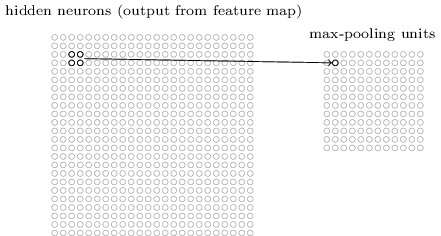

Average-pooling and/or L2-pooling are similar but take the average and/or the square root of the sum of squares of the activations in the regions respectively.

---

**Could you argue why pooling is a useful tool? And can you think of reasons when to use which type?**

---

Now we will implement our own max pooling layer for 2D inputs.


In [41]:
class MaxPool2d(object):
    """
    2D max pooling layer
    """

    def __init__(self, kernel_size, stride=1, padding=0):
        """
        Initialize the layer with given params

        Args:
            kernel_size: height and width of the receptive field of the layer
                in pixels.
            stride: # pixels between adjacent receptive fields in both
                horizontal and vertical directions.
            padding: # pixels that is used to zero-pad the input.
        """

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding


    def forward(self, x):
        """
        Forward pass of max pooling layer

        Args:
            x: input tensor with shape of (N, C, H, W)

        Returns:
            y: output tensor with shape of (N, C, H', W') where
                H' = 1 + (H + 2 * padding - kernel_size) / stride
                W' = 1 + (W + 2 * padding - kernel_size) / stride
        """
        # (We won’t use x_padded in forward so the argmax locations match backward.)
        # x_padded = torch.nn.functional.pad(x, [self.padding] * 4)

        # Unpack dims
        N, C, H, W = x.shape
        KS = self.kernel_size

        # Output sizes
        Hp = 1 + (H + 2 * self.padding - KS) // self.stride
        Wp = 1 + (W + 2 * self.padding - KS) // self.stride

        # Combine (N, C) for faster window processing
        y = torch.empty((N * C, Hp, Wp), dtype=x.dtype, device=x.device)

        # Loop over output spatial locations
        for i in range(Hp):
            h_off = i * self.stride
            for j in range(Wp):
                w_off = j * self.stride

                # Take KxK window from the *unpadded* input, then flatten per (N*C)
                window = x[:, :, h_off:h_off+KS, w_off:w_off+KS].reshape(N * C, -1)

                # Max over the K*K window → one value per (N*C)
                y[:, i, j] = window.max(dim=1).values

        # Reshape back to (N, C, Hp, Wp)
        y = y.reshape(N, C, Hp, Wp)

        # Cache *un-padded* x to match backward implementation
        self.cache = x
        return y

    def backward(self, dupstream):
        """
        Backward pass of max pooling layer: calculate gradients of loss with
        respect to weight and bias and return downstream gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        # You don't need to implement the backward pass. Instead we give it to
        # you for free.

        # Unpack cache
        x = self.cache

        # Create an empty dx tensor to accumulate the gradients on.
        dx = torch.zeros_like(x)

        # Unpack needed dimensions
        N, C, Hp, Wp = dupstream.shape

        # Loop through dupstream
        for i in range(Hp):
            for j in range(Wp):

                # Calculate offset for current window on input
                h_offset = i * self.stride
                w_offset = j * self.stride

                # Get current window of input and gradient of the input
                window = x[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size].reshape(N*C, -1)

                # Find the location of maximums
                indices = window.argmax(dim=1)

                # Create a tensor for gradients of the current window
                dwindow = torch.zeros_like(window)

                # Gradients flow through locations of maximums
                dwindow[torch.arange(N*C), indices] += dupstream[:, :, i, j].view(-1)

                # Sum the gradient of the window to actual gradient of input
                dx[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size] += dwindow.reshape(N, C, self.kernel_size, self.kernel_size)

        return dx

**Test max pooling layer**

We will validate our implementation using PyTorch's max pooling implementation.

In [42]:
# Define input and layer dimensions
n_samples, height, width, in_channels = 5, 10, 10, 3
kernel_size, stride, padding = 2, 2, 0

# Make random input tensor
x = torch.randn((n_samples, in_channels, height, width), dtype=torch.float32)


# Create a layer from the MaxPool2d object class above
layer = MaxPool2d(kernel_size, stride=stride, padding=padding)
# Forward pass
y = layer.forward(x)


# Create a PyTorch version of max pooling layer to test our implementation
torch_layer = nn.MaxPool2d(kernel_size, stride, padding)
# Forward pass
torch_y = torch_layer(x)


# What will be the shape of output y?
print('Shape of output is:', y.shape)
print('Our output is correct:', torch.allclose(y, torch_y, atol=1e-6))

Shape of output is: torch.Size([5, 3, 5, 5])
Our output is correct: True


Let's also test the backward pass of max pooling.

In [43]:
# Define input and layer dimensions
n_samples, height, width, in_channels = 5, 10, 10, 3
kernel_size, stride, padding = 2, 2, 0

# Make random input tensor
x = torch.randn((n_samples, in_channels, height, width), dtype=torch.float32)

# Create a layer from the MaxPool2d object class above
layer = MaxPool2d(kernel_size, stride=stride, padding=padding)
# Forward pass
y = layer.forward(x)


# We create a copy of the input tensor so we can use x for all other layers
# without overwriting its gradients. We will use this at the next step to test
# backward pass.
torch_x = x.detach()
# Enable requires_grad to make PyTorch computatinoal graph to calculate
# gradients
torch_x.requires_grad = True
# Create a PyTorch version of max pooling layer to test our implementation
torch_layer = nn.MaxPool2d(kernel_size, stride, padding)
# Forward pass
torch_y = torch_layer(torch_x)


# Define upstream gradient dL/dy as ones
dy = torch.ones_like(y)

# Backward pass
dx = layer.backward(dy)

# Perform bacward pass
torch_y.backward(dy)

# What will be the shape of gradient of x w.r.t. y?
print('Shape of gradient x is:', dx.shape)
print('Shape is correct:', dx.shape == torch_x.grad.shape)

# Compare gradients of x w.r.t. y using torch.allclose
dx_same = torch.allclose(dx, torch_x.grad, atol=1e-6)
print('dx identical:', dx_same)

Shape of gradient x is: torch.Size([5, 3, 10, 10])
Shape is correct: True
dx identical: True


## A3.3 Convolutional Neural Networks

Time to implement our first Convolutional Neural Network (CNN)! First, we will implement our own model. Second, we will implement same model with PyTorch and finally we will compare them.

CNNs are consisting of several convolutional layers in sequence. We are going to implement the following network architecture:

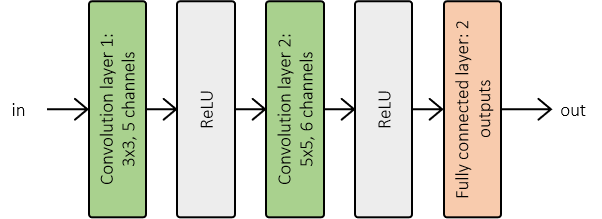

Observe that the final stage conveys a fully connected layer again.

---

**Why would an image classifier have such an ending stage? hint: it is often called the *decoder***

---

Hint for implementation: make sure you fully understand the architecture of above-mentioned network.

---

**What are the kernel sizes? How many channels does every layer has? hint: think in shapes (or arrays).**

---

We need Linear and ReLU layers. Since you imlemented them in the previous assigments, we give them for free.

In [44]:
class Linear(object):
    """
    Fully connected layer.

    Args:
        in_features: number of input features
        out_features: number of output features
    """

    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()

        # Define placeholder tensors for layer weight and bias. The placeholder
        # tensors should have the correct dimension according to the in_features
        # and out_features variables.
        self.weight = torch.Tensor(in_features, out_features)
        self.bias = torch.Tensor(out_features)

        # Initialize parameters
        self.init_params()

        # Define a cache varible to save computation, because some of the
        # forward pass values would be used during backward pass.
        self.cache = None

        # Define variables to store the gradients of the weight and bias
        # calculated during the backward pass
        self.weight_grad = None
        self.bias_grad = None

    def init_params(self, std=1.):
        """
        Initialize layer parameters. Sample weight from Gaussian distribution
        and bias uniform distribution.

        Args:
            std: Standard deviation of Gaussian distribution (default: 1.0)
        """

        self.weight = std*torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)

    def forward(self, x):
        """
        Forward pass of linear layer: multiply input tensor by weights and add
        bias. Store input tensor as cache variable.

        Args:
            x: input tensor with shape of (N, d1, d2, ...) where
                d1 x d2 x ... = in_features

        Returns:
            y: output tensor with shape of (N, out_features)
        """

        x = x.view(x.shape[0], -1)
        y = torch.mm(x, self.weight) + self.bias
        self.cache = x

        return y

    def backward(self, dupstream):
        """
        Backward pass of linear layer: calculate gradients of loss with respect
        to weight and bias and return downstream gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        x = self.cache
        dx = torch.mm(dupstream, self.weight.T)
        self.weight_grad = torch.mm(x.T, dupstream)
        self.bias_grad = torch.sum(dupstream, dim=0)

        return dx

class ReLU(object):
    """
    ReLU non-linear activation function.
    """

    def __init__(self):
        super(ReLU, self).__init__()

        # Define a cache varible to save computation, because some of the
        # forward pass values would be used during backward pass.
        self.cache = None

    def forward(self, x):
        """
        Forward pass of ReLU non-linear activation function: y=max(0, x).

        Args:
            x: input tensor

        Returns:
            y: output tensor
        """

        y = torch.clamp(x, min=0)  # forward pass
        self.cache = x

        return y

    def backward(self, dupstream):
        """
        Backward pass of ReLU non-linear activation function: return downstream
        gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        # Making sure that we don't modify the incoming upstream gradient
        dupstream = dupstream.clone()

        x = self.cache
        dx = dupstream
        dx[x < 0] = 0

        return dx

We can now implement the CNN model given in above picture.

In [45]:
class CNN(object):
    """
    3-block CNN:
      [Conv -> ReLU -> MaxPool] x 2  ->  Flatten  ->  Linear(out_features)
    """

    def __init__(self, in_channels, hidden_channels, out_features):
        """
        Args:
            in_channels:   input channels (e.g., 1 for grayscale, 3 for RGB)
            hidden_channels: [h1, h2] number of filters in the two conv layers
            out_features:  output dimension (e.g., #classes)
        """
        assert len(hidden_channels) == 2, "hidden_channels must be [h1, h2]"
        h1, h2 = hidden_channels

        self.layers = []

        # Block 1: Conv -> ReLU -> MaxPool
        self.layers.append(Conv2d(in_channels=in_channels, out_channels=h1,
                                  kernel_size=3, stride=1, padding=1))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=2, stride=2, padding=0))

        # Block 2: Conv -> ReLU -> MaxPool
        self.layers.append(Conv2d(in_channels=h1, out_channels=h2,
                                  kernel_size=3, stride=1, padding=1))
        self.layers.append(ReLU())
        self.layers.append(MaxPool2d(kernel_size=2, stride=2, padding=0))

        # Linear head will be created lazily (we need to know spatial size)
        self.out_features = out_features
        self.fc = None  # to be instantiated on first forward

        # Optionally init conv params now
        self.reset_params(std=1.0)

    def reset_params(self, std=1.0):
        """Apply init_params to layers that have it."""
        for layer in self.layers:
            if hasattr(layer, 'init_params'):
                layer.init_params(std=std)
        if self.fc is not None and hasattr(self.fc, 'init_params'):
            self.fc.init_params(std=std)

    def _ensure_fc(self, x):
        """Create the Linear head when we first know the flattened size."""
        if self.fc is None:
            N, C, H, W = x.shape
            in_feats = C * H * W
            self.fc = Linear(in_features=in_feats, out_features=self.out_features)
            # Optional: init the linear too
            if hasattr(self.fc, 'init_params'):
                self.fc.init_params(std=1.0)

    def forward(self, x):
        # Two conv blocks
        for layer in self.layers:
            x = layer.forward(x)

        # Flatten to (N, C*H*W)
        N, C, H, W = x.shape
        x = x.reshape(N, C * H * W)

        # Create linear head if needed, then apply it
        self._ensure_fc(x.reshape(N, C, H, W))  # pass 4D to compute in_feats cleanly
        x = self.fc.forward(x)
        return x

    def backward(self, dupstream):
        # Backprop through linear head
        dx = self.fc.backward(dupstream)

        # Unflatten back to (N, C, H, W) for the conv stack
        # We cached the input shape when creating self.fc, reconstruct it:
        # Easiest is to remember last feature-map shape during forward:
        # (Add a small cache in forward)
        # Here we compute it from fc input size; better store it.
        # Assuming we cached it as self._last_feat_shape in forward:
        # dx = dx.reshape(self._last_feat_shape)
        # If you didn’t cache it, do this: (requires storing last (N,C,H,W))
        # (Below shows a simple version if you add self._last_feat_shape in forward.)

        # --- Add this in forward before flattening: self._last_feat_shape = (N, C, H, W)
        NCHW = getattr(self, "_last_feat_shape", None)
        if NCHW is None:
            raise RuntimeError("Missing cached feature map shape; cache it in forward.")
        dx = dx.reshape(*NCHW)

        # Backprop through conv/pool/ReLU layers in reverse
        for layer in reversed(self.layers):
            dx = layer.backward(dx)
        return dx

    def optimizer_step(self, lr):
        # Update conv/pool/activation layers where applicable
        for layer in self.layers:
            if hasattr(layer, 'weight'):
                layer.weight -= layer.weight_grad * lr
            if hasattr(layer, 'bias'):
                layer.bias -= layer.bias_grad * lr

        # Update linear head
        if self.fc is not None:
            if hasattr(self.fc, 'weight'):
                self.fc.weight -= self.fc.weight_grad * lr
            if hasattr(self.fc, 'bias'):
                self.fc.bias -= self.fc.bias_grad * lr

Try your implementation by running below cell.

In [46]:
# Define input and layer dimensions
n_samples, height, width, in_channels = 1, 16, 16, 3
hidden_channels, out_features = [5, 6], 2

# Make random input tensor
x = torch.randn((n_samples, in_channels, height, width), dtype=torch.float32)


# Create a layer from the Conv2d object class above
cnn = CNN(in_channels, hidden_channels, out_features)
# Forward pass
y = cnn.forward(x)

# What will be the shape of output y?
print('Shape of output y:', y.shape)

Shape of output y: torch.Size([1, 2])


Implement the same CNN with the above one but this time as a subclass of `nn.Module` and using the predefined layers of PyTorch's `nn` library.

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TorchCNN(nn.Module):
    """
    PyTorch 3-learnable-layer CNN mirroring:
      [Conv -> ReLU -> MaxPool] -> [Conv -> ReLU -> MaxPool] -> Flatten -> Linear
    """
    def __init__(self, in_channels, hidden_channels, out_features,
                 pool_kernel=2, pool_stride=2, pool_padding=0):
        super().__init__()
        assert len(hidden_channels) == 2, "hidden_channels must be [h1, h2]"
        h1, h2 = hidden_channels

        self.conv1 = nn.Conv2d(in_channels, h1, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride, padding=pool_padding)
        self.conv2 = nn.Conv2d(h1, h2, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride, padding=pool_padding)

        self.fc = None
        self.out_features = out_features

    def _ensure_fc(self, x_flat):
        if self.fc is None:
            in_feats = x_flat.shape[1]
            self.fc = nn.Linear(in_feats, self.out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        N, C, H, W = x.shape
        x = x.view(N, C * H * W)
        self._ensure_fc(x)
        x = self.fc(x)
        return x

Try your implementation by running the next cell.

In [48]:
# Build Torch model with the same pooling config as custom CNN
torch_cnn = TorchCNN(in_channels, hidden_channels, out_features,
                     pool_kernel=2, pool_stride=2, pool_padding=0)

# Copy convs from custom cnn.layers: [0]=Conv, [1]=ReLU, [2]=Pool, [3]=Conv, [4]=ReLU, [5]=Pool
torch_cnn.conv1.weight.data.copy_(cnn.layers[0].weight)
torch_cnn.conv1.bias.data.copy_(cnn.layers[0].bias)

torch_cnn.conv2.weight.data.copy_(cnn.layers[3].weight)
torch_cnn.conv2.bias.data.copy_(cnn.layers[3].bias)

# Run a dummy forward to instantiate fc with the correct in_features (=96 now)
_ = torch_cnn(x)

# Copy linear from custom cnn.fc (NOT cnn.layers[5])
srcW = cnn.fc.weight            # likely shape (in_features, out_features) = (96, 2)
dstW = torch_cnn.fc.weight.data # torch shape (out_features, in_features) = (2, 96)

# transpose if needed
if srcW.shape == dstW.shape:
    dstW.copy_(srcW)
elif srcW.t().shape == dstW.shape:
    dstW.copy_(srcW.t())
else:
    raise ValueError(f"Mismatch: src {tuple(srcW.shape)} vs dst {tuple(dstW.shape)}")

# bias (should be (out_features,))
torch_cnn.fc.bias.data.copy_(cnn.fc.bias)

# Verify outputs
torch_y = torch_cnn(x)
print('Outputs match:', torch.allclose(y, torch_y, atol=1e-6))

Outputs match: True


We will not validate the backward pass. From here on we will continue in PyTorch.

We can inspect the precise build-up of the a PyTorch network. For this, we can use `torchsummary.summary` (see setup). By specifying the input size as second input for the function, it will output the structure of the network including the amount of learnable parameters and some other details (e.g. bitsizes).

In [49]:
summary(torch_cnn, (3, 16, 16), device='cpu') # (in_channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 16, 16]             140
         MaxPool2d-2              [-1, 5, 8, 8]               0
            Conv2d-3              [-1, 6, 8, 8]             276
         MaxPool2d-4              [-1, 6, 4, 4]               0
            Linear-5                    [-1, 2]             194
Total params: 610
Trainable params: 610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


## A3.4 CNN's for MNIST classification
In this exercise we will proceed with classifying handwritten digits.

Recall:
*The MNIST dataset consists of a training set of 60,000 and a test set of 10,000 samples of 28x28 pixels. In every training iteration we will sample a random batch of 64 data samples (without replacement) to calculate the loss, gradients and update the weights. This random sampling is where the 'Stochastic' in Stochastic Gradient Descent comes from. After every epoch, i.e. after having processed all sampels in the training set, we will evaluate the model on the test set.*

Let us first load and structure the data is similar fashion as before.



In [50]:
# Preprocessing data: convert to tensors and normalize by subtracting dataset
# mean and dividing by std.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Get data from torchvision.datasets
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Define data loaders used to iterate through dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:01<00:00, 7.29MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 311kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


It is always good practice to have a look at your data.

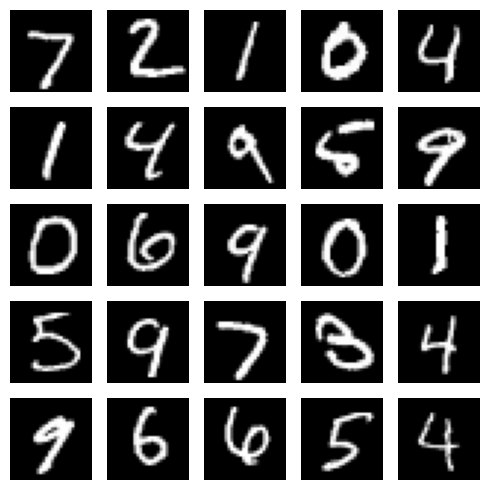

In [51]:
# Show some example images
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, _ = test_data[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

Before jumping to the training procedure, we would like to introduce two functions that could be useful. `try_gpu()` does a check if GPUs are available for allocated memory and/or computations. Every `tensor` in pytorch has a `to()` member function in which the device is specified on which the tensor is put. The default is generally CPU while in most cases GPU is beneficial.

---

**Can you think of a reason why?**

---
`'cuda:0'` is used for GPU and `'cpu'` for CPU. Make sure the network and its inputs both have the same device *type*. In addition you have to **make sure correct Runtime type is selected in colab**

In [52]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

During training, you often ask the network to be evaluated on some dataset. Especially computing the accuracy of the model must be done over and over again. The following function does exactly that for a given network and dataloader. Observe that the network should be put into evaluation mode using `net.eval` (similarly, it is easy to change the mode back to training using `net.train`)

In [53]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

We need a model to train. Let's define it.

In [54]:
class Net(nn.Module):
    """
    3-layer CNN network with max pooling

    Args:
        in_channels: number of features of the input image ("depth of image")
        hidden_channels: number of hidden features ("depth of convolved images")
        out_features: number of features in output layer
    """

    def __init__(self, in_channels, hidden_channels, out_features):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, hidden_channels[0],
                               kernel_size=3,
                               padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(hidden_channels[0], hidden_channels[1],
                               kernel_size=5,
                               padding=2)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(7*7*hidden_channels[1], out_features)

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        # Activation function
        x = self.relu1(x)
        # Max pool
        x = self.max_pool1(x)
        # Second convolutional layer
        x = self.conv2(x)
        # Activation function
        x = self.relu2(x)
        # Max pool
        x = self.max_pool2(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc(x)
        return x

Before using the network, let's first inspect it.

In [55]:
# Define the channel sizes and output dim
in_channels = 3
hidden_channels = [5, 6]
out_features = 2

net = Net(in_channels, hidden_channels, out_features)
summary(net, (3, 28, 28), device='cpu') # (in_channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 28, 28]             140
              ReLU-2            [-1, 5, 28, 28]               0
         MaxPool2d-3            [-1, 5, 14, 14]               0
            Conv2d-4            [-1, 6, 14, 14]             756
              ReLU-5            [-1, 6, 14, 14]               0
         MaxPool2d-6              [-1, 6, 7, 7]               0
            Linear-7                    [-1, 2]             590
Total params: 1,486
Trainable params: 1,486
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


You are ready to train your first CNN! Please use the same architecture as before (including pooling). Stochastic gradient descent and cross-entropy are used as the optimizer and loss function, respectively. You are very welcome, actually encouraged, to change as many settings as you like (e.g. amount of iterations/epochs, learning rate, loss function or even the network).

---

**Can you spot any differences between the (fully connected) network's process from the previous assignment and this one? Do the loss and performance curves look healthy? Is it at all performing sufficiently better? If not, can you think of a reason why that is?**

---

Recall the steps to be taken during training:

```
1. initialize:
 a. load batches
 b. create classes
 c. initialize network
2. while not converged:
 a. feed training sample to network to predict output (forward step)   <---
 b. compare prediction to label (compute loss)                             |
 c. use comparison to update network parameters (backward step)        ----
```

In [59]:
in_channels = 1 # Black-white images in MNIST digits
hidden_channels = [5, 6]
out_features = 10

# Training parameters
learning_rate = 0.001
epochs = 3

# Initialize network
net = Net(in_channels, hidden_channels, out_features)
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

# Try using gpu instead of cpu
device = try_gpu()

for epoch in range(epochs):

    # Network in training mode and to device
    net.train()
    net.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = net(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss.item())          # <-- use .item()

        # Backward computation and update
        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
    test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))

    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

Epoch: 1
Accuracy of train set: 77%
Accuracy of test set: 78%

Epoch: 2
Accuracy of train set: 88%
Accuracy of test set: 88%

Epoch: 3
Accuracy of train set: 90%
Accuracy of test set: 91%



Let's draw training curves to better understand what's going on.



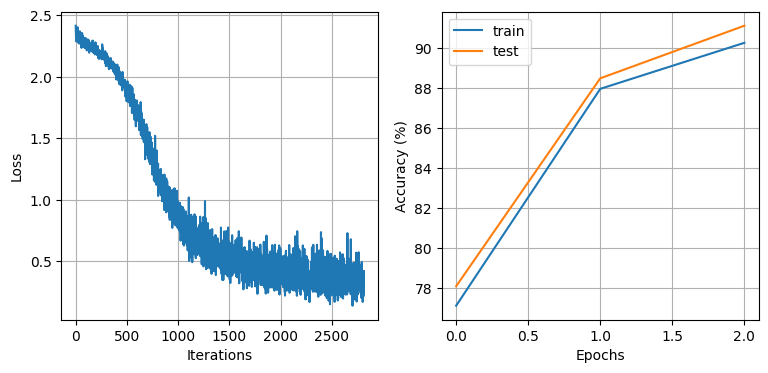

In [60]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.legend()
plt.grid()

---

**Why does training curve fluctuate?**

---

Your network can now classify handwritten digits better than the previous fully connected network. Well done!

This concludes the third assignment. In the next assignment you will learn how to regularize your networks.